# Проект по созданию модели для определения рыночной стоимости автомобиля

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загрузка и обзор данных

In [4]:
initial_df = pd.read_csv('/Users/semionkaminsky/Desktop/YP/Numerical methods/autos.csv')
print(initial_df.info())
display(initial_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Видим, что есть, над чем работать: пропуски, категориальные переменные, даты. Для начала немного подробнее остановимся на категориальных и численных переменных.

In [6]:
df = initial_df
df.columns = df.columns.str.lower()

In [7]:
cat_columns = ['brand', 'vehicletype', 'model', 'registrationyear', 'gearbox', 'fueltype', 'notrepaired', 'postalcode', 'registrationmonth']
for cat in cat_columns:
    display(df[cat].value_counts())

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicletype, dtype: int64

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: registrationyear, Length: 151, dtype: int64

manual    268251
auto       66285
Name: gearbox, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

no     247161
yes     36054
Name: notrepaired, dtype: int64

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
21782      1
9517       1
29367      1
38325      1
82404      1
Name: postalcode, Length: 8143, dtype: int64

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: registrationmonth, dtype: int64

Промежуточный комментарий:
1. `vehicletype`, `registrationmonth` и `fueltype` - легко поддадутся OHE.
2. `gearbox` и `notrepaired` - переквалифицируем в логические.
3. Очень хорошо видны ошибки в `registrationyear`: там и машины из будущего, и до непосредственного изобретения автомобилей. Одним словом, претенденты на удаление.
4. В столбце `model` тоже достаточно много уникальных значений. Но возможно стоит выделить самые частые модели, а остальные отправить в "other"
5. В `postalcode` много разных вариантов значений. На самом деле, довольно интересная переменная. По факту она характеризует географическое положения региона продажи. С одной стороны, это хорошо, потому что у нас есть численная репрезентация местоположения. Однако тут могут возникать сложности из-за того, что сама переменная не числовая (если сложить два почтовых индекса, мы получим кусочек мусора), а применить кодировку сложно из-за количества уникальных значений. Возможно, имеет смысл "разбить" этот рейндж индексов на n географических искусственных категорий и применить OHE. Потом посмотрим, что из этого получится.

In [8]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'registrationyear'}>,
        <AxesSubplot:title={'center':'power'}>],
       [<AxesSubplot:title={'center':'kilometer'}>,
        <AxesSubplot:title={'center':'registrationmonth'}>,
        <AxesSubplot:title={'center':'numberofpictures'}>],
       [<AxesSubplot:title={'center':'postalcode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

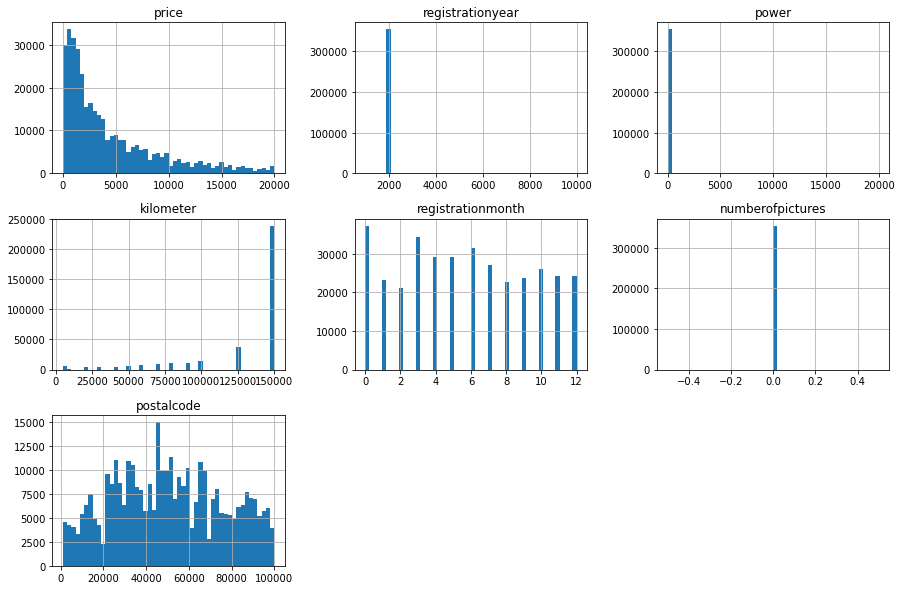

In [9]:
df.hist(figsize = (15, 10), bins = 50)

In [10]:
print(df['numberofpictures'].unique())
df.drop('numberofpictures', axis = 1, inplace = True)

[0]


Плохо видно, что происходит с power. Разобъем на 2 гистограммы и посмотрим.

<AxesSubplot:>

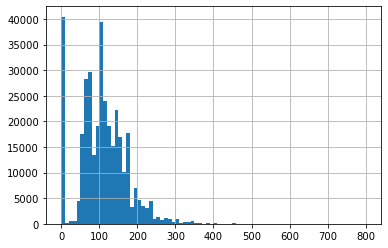

In [11]:
df['power'].hist(bins = 80, range = (0, 800))

<AxesSubplot:>

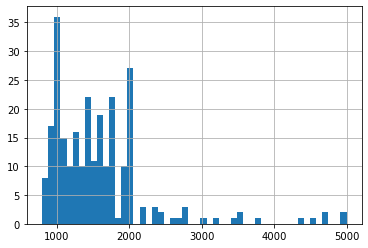

In [12]:
df['power'].hist(bins = 50, range = (800, 5000))

1. И что мы видим? Бросается в глаза, что в `numberofpictures` только нули и есть. Сразу проверили - сразу удалили. Нечего хлам держать.
2. `price` - если честно, ожидал нормальное распределение. В итоге получили Пуассона. Что странно: есть совсем низкие цены (до 300 евро). Их придется удалить - это выглядит как набор "случайных" объявлений или ситуаций, когда человек "сливает" машину. Хорошо бы спросить у заказчика, что это такое, но сейчас мы можем только удалить эти наблюдения из всего датасета.
3. По гистограмме `registrationyear` еще раз убедимся, что выбросы есть. Но их, по видимому, немного - это радует.
4. `postalcode` - скорее всего, это равномерное распределение с большим влиянием шумов.
5. `registrationmonth` - примерно поровну.
6. В `power` видим много выбросов. Нужно будет определить "адекватный" отрезок мощности и заполнить "хвост" медианными значениями. Или совсем убрать - посмотрим.
7. По таблице распределений мы можем сделать довольно интересное наблюдение: у большинства числовых параметров есть очень "ровная" граница. Напрашивается вывод, что она могла быть задана искусственно. Посмотрим, что можно сделать.

### План предобработки данных:
#### Категориальные, логические переменные и даты
1. [x] `vehicletype` заполним по моде. Также, переведем в численный вид. 
1. [x] С `gearbox` поступим так же, как и  с`vehicletype`.
1. [x] С `fueltype` поступим так же, как с `vehicletype`.
1. [x] С `notrepaired` поступим так же, как с `vehicletype`.
1. [x] `registrationyear` - удалим строки со значениями больше 2021 и меньше 1970 (вряд ли они в ходу). Возможно, получится применить OHE.
1. [x] Пропуски в `model` заполним с значением "other". Также, посмотрим, можно ли выделить несколько "главных" моделей, а остальные отправить в "other". Возможно, тут получится кодировать данные.
1. [x] Для `registrationmonth` применим OHE.
1. [x] К `brand` применим OHE.
1. [x] `postalcode` поделим на 10 категорий и применим OHE.
1. [x] `datecrawled`, `lastseen` и `datecreated` округлим до дня. Вообще вряд ли они имеют большое значение, но хотя бы так обработаем.

#### Числовые переменные
1. [x] Для `power` определим адекватный максимум, и удалим все значения, его превышающие.
1. [x] Далее сделаем единый пайплайн для числовых значений с заполнением пропусков с помощью Imputer, стандартизацией StandardScaler

In [13]:
# СРАЗУ УДАЛЯЕМ СТРОКИ В СООТВЕТСТВИИ С УСЛОВИЕМ
df = df.drop(df.query(
    'registrationyear > 2021 or registrationyear < 1970 or power > 800 or price < 300 or power < 60').index)

In [14]:
#НАПИШЕМ КЛАСС ДЛЯ ТОГО, ЧТОБЫ УДОБНО ВСТРАИВАТЬ ВЫБОР ОБРАБАТЫВАЕМЫХ ИЗМЕРЕНИЙ В ПАЙПЛАЙН
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attributes]

In [15]:
num_names = ['power', 'kilometer']
#ОСНОВНАЯ ОБРАБОТКА ЧИСЛЕННЫХ ПРЕМЕННЫХ
num_pipeline = Pipeline([
    ('num_selector', DataFrameSelector(attributes = num_names)),
    ('imputer', SimpleImputer(strategy = 'median')), #заполним пропуски с помощью SimpleImputer
    #('stdscaler', StandardScaler()) #стандартизация данных для улучшения качества линейной регрессии
])
#переведем численную часть подготовленных данных в DataFrame для удобства работы с индексами при будущем объединении всего датасета
nums = pd.DataFrame(num_pipeline.fit_transform(df), columns = num_names)

In [16]:
dates_names = ['lastseen', 'datecreated', 'datecrawled']
#ПЕРЕВОДИМ ДАТЫ В СООТВЕТСТВУЮЩИЙ ФОРМАТ И ОКРУГЛЯЕМ ДО ДНЯ
for name in dates_names:
    df[name] = pd.to_datetime(df[name]).dt.round('D')
dates = df[dates_names]
dates.index = nums.index

#ЧТОБЫ ПЕРЕВЕСТИ В ЧИСЛЕННЫЙ ВИД, РАЗБИВАЕМ КАЖДЫЙ СТОЛБЕЦ НА ТРИ: ДЕНЬ НЕДЕЛИ, ГОД, МЕСЯЦ
def weekday(date):
    return date.weekday()
def year(date):
    return date.year
def month(date):
    return date.month

timeline = [weekday, year, month]
dates_prepared = pd.DataFrame(index = dates.index)
for name in dates_names:
    for time in timeline:
        dates_prepared = pd.merge(dates_prepared, dates[name].apply(time), left_index = True, right_index = True)

In [17]:
df['model'] = df['model'].fillna('other') #пропуски в model заполняем значением other
df['postal_cat'] = np.ceil(df['postalcode'] / 15000) #получаем категории индекса в столбец postal_cat
gr1_names = ['vehicletype', 'gearbox', 'fueltype', 'notrepaired'] #те переменные, которые мы решили заполнить по моде
mode_imputer = SimpleImputer(strategy = 'most_frequent') #для заполнения используем SimpleImputer
df[gr1_names] = mode_imputer.fit_transform(df[gr1_names])

df = pd.merge(df.drop(dates_names, axis = 1), dates_prepared, left_index = True, right_index = True)

#К ОСНОВНЫМ КАТЕГОРИАЛЬНЫМ ПЕРЕМЕННЫМ ДОБАВИМ ЗАРАНЕЕ ПОДГОТОВЛЕННЫЕ ДАТЫ, ЧТОБЫ ИСПОЛЬЗОВАТЬ НА НИХ OHE
cat_names = ['vehicletype', 'gearbox', 'fueltype', 'notrepaired', 'registrationyear', 
             'model', 'registrationmonth', 'brand', 'postal_cat'] + list(dates_prepared.columns) 

#ОСНОВНАЯ ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ
cat_pipeline = Pipeline([
    ('cat_selector', DataFrameSelector(attributes = cat_names)),
    ('OHE', OneHotEncoder(drop = 'first', sparse = False))
])
#переведем категориальную часть подготовленных данных в DataFrame для удобства работы с индексами при будущем объединении всего датасета
cats = pd.DataFrame(cat_pipeline.fit_transform(df))

In [18]:
prepared_data = pd.merge(nums, cats, left_index=True, right_index=True)
prepared_data

,power,kilometer,0,1,2,3,4,5,6,7,...,385,386,387,388,389,390,391,392,393,394
0,190.0,125000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,163.0,125000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,75.0,150000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,69.0,90000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,102.0,150000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218111,220.0,150000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
218112,75.0,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
218113,125.0,150000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
218114,193.0,150000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Промежуточный комментарий
Итак, мы получили данные, с которыми можно работать. Уже предвкушаю, как долго будут обучаться модели... Но как сказал один великий человек, в математике главное честность. А уж если мы можем подготовить данные надлежащим образом, то полениться было бы нечестно.

Теперь объединим данные и временно вернем столбец `brand`. Он нужен нам, чтобы провести стратификацию и разделить выборку на train и test.

In [19]:
brand = df['brand']
brand.index = prepared_data.index
prepared_data['brand'] = brand
#вернули brand

target = df['price']
target.index = prepared_data.index
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
#создали переменную target из столбца изначального датасета
#уточним, что в подготовленных данных нет целевого признака, его отбросил DataFrameSelector

for train_idx, test_idx in split.split(prepared_data, prepared_data['brand']):
    print('test_idx:',test_idx)
    print('train_idx:', train_idx)
    features_train = prepared_data.iloc[train_idx].drop('brand', axis = 1)
    target_train = target.iloc[train_idx]
    features_test = prepared_data.iloc[test_idx].drop('brand', axis = 1)
    target_test = target.iloc[test_idx]
    
print('Размер тестовой выборки:', features_test.shape)
print('Размер обучающей выборки:', features_train.shape)
print('Датасет разделен на тестовую и обучающие выборки в соотношении',
      round(features_test.shape[0] / df.shape[0], 3) * 10,'к', 
      round(features_train.shape[0] / df.shape[0], 3) * 10)

test_idx: [155731  23455 129508 ...  80404  55652  97616]
train_idx: [142346  47702  41710 ... 183767  30780  78404]
Размер тестовой выборки: (43624, 397)
Размер обучающей выборки: (174492, 397)
Датасет разделен на тестовую и обучающие выборки в соотношении 2.0 к 8.0


In [20]:
pipeline_num_2 = Pipeline([
    ('num_selector', DataFrameSelector(num_names)),
    ('std_scaler', StandardScaler())
])
features_train[num_names] = pipeline_num_2.fit_transform(features_train)
features_test[num_names] = pipeline_num_2.transform(features_test)

## Обучение моделей - 1
Итак, мы "по максимуму" обработали данные, разделили их на обучающую и тестовую выборки. Теперь мы готовы к обучению и тюнингу моделей. В этом нам поможет RandomizedSearchCV. 

In [21]:
#создаем пустые модели
best_lreg = LinearRegression(normalize = False)
tree = DecisionTreeRegressor(random_state = 42)
forest = RandomForestRegressor(random_state = 42)

categories = features_train.drop(num_names, axis = 1).columns.values
sgb = LGBMRegressor(random_state = 42, n_jobs = -1, silent = True, categorical_feature = categories)

#формируем сетки гиперпараметров
tree_grid = {'max_depth': range(1, 50)}
forest_grid = {'max_depth': range(1, 30), 'n_estimators': range(1, 150, 10)}
sgb_grid = {'n_estimators': range(1, 200, 10), 'max_depth': range(1, 50), 
            'learning_rate': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 
            'num_leaves': range(0, 50, 10)}

#готовим классы для обучения
best_tree = RandomizedSearchCV(tree, n_jobs = -1, n_iter = 9, 
                               param_distributions = tree_grid, random_state = 42, 
                               scoring = 'neg_mean_squared_error', cv = 5)
best_forest = RandomizedSearchCV(forest, n_jobs = -1, n_iter = 3, 
                               param_distributions = forest_grid, random_state = 42, 
                               scoring = 'neg_mean_squared_error', cv = 2)
best_sgb  = RandomizedSearchCV(sgb, n_jobs = -1, n_iter = 9, 
                               param_distributions = sgb_grid, random_state = 42, 
                               scoring = 'neg_mean_squared_error', cv = 5)

In [22]:
import time
#ФУНКЦИЯ ДЛЯ АВТОМАТИЗАЦИИ ОБУЧЕНИЯ, ЗАПОМИНАНИЯ МОДЕЛЕЙ И ВЫВОДА ПАРАМЕТРОВ ОБУЧЕНИЯ
def learner(estimator, 
            name, features_train = features_train, 
            target_train = target_train, 
            features_test = features_test,
            target_test = target_test):
    categories = features_train.drop(num_names, axis = 1).columns
    model_start = time.time()
    estimator.fit(features_train, target_train)

    model_end = time.time()
    test_predictions = estimator.predict(features_test)
    predict_end = time.time()
    learning_time = model_end - model_start
    predict_time = predict_end - model_end
    rmse = mean_squared_error(target_test, test_predictions) ** 0.5
    try:
        params = estimator.best_params_
        print('Подобранные гиперпараметры:', params)
        print('Оценка модели', name,' RMSE =', rmse)
        print('Время, потраченное на обучение модели:', learning_time, 'сек.')
        print('Время, потраченное на инференс:', predict_time)
        print()
        return pd.Series([estimator, rmse, params , learning_time, predict_time], 
                         index = ['Модель', 'Гиперпараметры', 'RMSE', 'Время обучения', 'Время инференса'])
    except:
        params = estimator.get_params()
        print('Подобранные гиперпараметры:', params)
        print('Оценка модели', name,' RMSE =', rmse)
        print('Время, потраченное на обучение модели:', learning_time, 'сек.')
        print('Время, потраченное на инференс:', predict_time)
        print()
        return pd.Series([estimator, rmse, params , learning_time, predict_time], index = ['Модель', 'Гиперпараметры', 'RMSE', 'Время обучения', 'Время инференса'])

In [ ]:
models = pd.Series([best_lreg, best_tree, best_forest, best_sgb], 
                   index = ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг'])
result_1 = pd.DataFrame(columns = ['Модель','Гиперпараметры' , 'RMSE', 'Время обучения', 'Время инференса'])
for idx in ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг']:
    result_1 = result_1.append(learner(models[idx], idx), ignore_index = True)

Подобранные гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
Оценка модели Линейная регрессия  RMSE = 2143.434364677307
Время, потраченное на обучение модели: 1.8827762603759766 сек.
Время, потраченное на инференс: 0.017799854278564453

Подобранные гиперпараметры: {'max_depth': 18}
Оценка модели Решающее дерево  RMSE = 2078.2865905753656
Время, потраченное на обучение модели: 82.57678008079529 сек.
Время, потраченное на инференс: 0.07059407234191895



In [ ]:
#ПРОВЕРКА НА АДЕКВАТНОСТЬ
const_pred = pd.Series(data = target_train.median(), index = target_test.index)
print('RMSE константного предсказания =', mean_squared_error(const_pred, target_test) ** 0.5)

### Результат
Итак, мы получили 4 модели, они хранятся в столбце "Модель" объекта DataFrame `result_1`, к нему мы обратимся чуть позже - сейчас нам достаточно выведеенных на экран значений. Итак, по RMSE лучшая модель - случайный лес (1766 евро). Да, много, но проверку на адекватность проходит, причем RMSE нашей модели лучше почти в 3 раза. Если думать, почему модель все же не так точна, как нам бы того хотелось, то тут три варианта:
1. У нас нет каких-то важных features. Возможно, выгрузили не все данные, а может быть существуют специфические характеристики ценообразования на рынке автомобилей, которые из сервиса не получишь.
2. Данные плохие. Плохие в том смысле, что есть очень много выбросов, систематических включений в данные, которые мы не можем отловить без детального знания о работе сервиса, специфике выгрузки данных, поведении пользователей.
3. Ценообразование несистемно. Возможно, цена на автомобиль диктуется не столько характеристиками, сколько волей случая. Тут бы помогло знание о том какие машины проданы, а кикие - нет. И если проданы, то в какой срок. Это бы стало своеобразным фильтром, с помощью которого можно понять, "принял" рынок эту цену (адекватна), отверг (завышена) или "слопал" за считанные часы (занижена).
4. Дело в нас. Возможно, из-за довольно масштабного применения OHE, модели, которые в нем не очень-то нуждаются (лес, дерево и бустинг), стали работать хуже. Попробуем обучить этих ребят на данных после OrdinalEncoder, но без OHE. 

## Обучение моделей - 2

In [ ]:
target = df['price']

cats = df[cat_names]
ord_enc = OrdinalEncoder()
cats = pd.DataFrame(ord_enc.fit_transform(cats), index = target.index)
categories = cats.columns.values

features = pd.merge(cats, nums, left_index = True, right_index = True)

In [ ]:
features_train_2, target_train_2 = features.iloc[train_idx], target.iloc[train_idx]
features_test_2, target_test_2 = features.iloc[test_idx], target.iloc[test_idx]

features_train_2[num_names] = pipeline_num_2.fit_transform(features_train_2)
features_test_2[num_names] = pipeline_num_2.transform(features_test_2)

sgb = LGBMRegressor(random_state = 42, n_jobs = -1, silent = True, categorical_feature = categories)
best_sgb  = RandomizedSearchCV(sgb, n_jobs = -1, n_iter = 9, 
                               param_distributions = sgb_grid, random_state = 42, 
                               scoring = 'neg_mean_squared_error', cv = 5)

In [ ]:
models = pd.Series([best_tree, best_forest, best_sgb], 
                   index = ['Решающее дерево', 'Случайный лес', 'Градиентный бустинг'])
result_2 = pd.DataFrame(columns = ['Модель','Гиперпараметры' , 'RMSE', 'Время обучения', 'Время инференса'])
for idx in ['Решающее дерево', 'Случайный лес', 'Градиентный бустинг']:
    result_2 = result_2.append(learner(estimator = models[idx], 
                            name = idx, features_train = features_train_2, 
                            target_train = target_train_2,
                            features_test = features_test_2, 
                            target_test = target_test_2),
                    ignore_index = True)

### Результат
Итак, расклад поменялся. Градиентный вышел в лидеры, с RMSE = 1636 евро. Немного лучше, но не критически. Зато модель стала значительно бысрее обучаться. Посмотрим, что у нас есть в результате, убедимся в своей правоте и приблизимся к концу.

In [ ]:
for result in result_1, result_2:
    result.columns = ['Модель', "RMSE", 'Гиперпараметры', 'Время обучения', 'Время инференса']

result_1.index = ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг']
result_2.index = ['Решающее дерево', 'Случайный лес', 'Градиентный бустинг']

display(result_1.drop(['Модель', 'Гиперпараметры'], axis = 1))
display(result_2.drop(['Модель', 'Гиперпараметры'], axis = 1))

In [ ]:
best_model = result_2['Модель']['Градиентный бустинг']
best_result = result_2.loc['Градиентный бустинг', :].drop('Модель')
best_result

## Выводы
Лучшая модель - градиентный бустинг. Сохранили ее в переменной `best_model`. Что ж, печально, что не удалось добиться реально крутого значения RMSE. Видимо, один или несколько пунктов из предыдущего раздела реализовались слихвой. Но радует, что модель легко проходит проверку на адекватность! 